# Name: Umad ul hassan Rai
# Exercise Sheet 2

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.types import StringType, StructType, StructField, Row
from pyspark.sql import Row
from pyspark.sql.functions import concat, col, lit, split, udf, size, lit
from pyspark.sql import functions as sf
from operator import add
import pandas as pd
import pyspark
import time
import csv


In [10]:
# initialise Spark Session
sparkSession = SparkSession.builder.appName("Exercise1").getOrCreate()
sc = sparkSession.sparkContext
sqlC = SQLContext(sc)

# Exercise 2.1 Advanced Analysis

In [11]:
# Using the same Dataframes as created in previous exercise.
# Using two columns as StringType (Later will assign second column (Papers_ID) to array.)
schema = StructType([
    StructField("User", StringType(), False),
    StructField("Papers_ID", StringType(), True)
])

# Creating DataFrame df for users_libraries
userDF = sqlC.read.schema(schema)\
        .option("header", 'False').option("delimiter", ";").csv("users_libraries.txt")


#userDF.show(10, False)
userDF.printSchema()
#userDF.show(20, False)


root
 |-- User: string (nullable = true)
 |-- Papers_ID: string (nullable = true)



In [12]:
# Creating Papers.csv DataFrame
# I didnt create schema for this DF, because at the end i needed two columns and wanted to change
# type of only paper_id column to IntegerType()
paperDF = sqlC.read.csv("papers.csv")
columns= ["paper_id", "type", "journal", "bookـtitle", "series", "publisher", "pages", "volume", "number", "year", "month", "postedat","address","title", "abstract"]
oldCols = paperDF.schema.names
for i, x in enumerate(oldCols):
    paperDF = paperDF.withColumnRenamed(x, columns[i])
#paperDF.show(2)
paperDF.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- bookـtitle: string (nullable = true)
 |-- series: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- pages: string (nullable = true)



In [13]:
#Type casting from str to array so i can apply explode function on papers_id column.
def str_to_arr(my_list):
    my_list = my_list.split(",")
    return [x for x in my_list]

str_to_arr_udf = udf(str_to_arr,ArrayType(StringType()))

userDF = userDF.withColumn('PapersID',str_to_arr_udf(userDF["Papers_ID"]))
userDF = userDF.drop("Papers_ID")
userDF.printSchema()
userDF.show(2)
userDF.printSchema()

root
 |-- User: string (nullable = true)
 |-- PapersID: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+--------------------+
|                User|            PapersID|
+--------------------+--------------------+
|f05bcffe7951de9e5...|[1158654, 478707,...|
|28d3f81251d94b097...|[3929762, 503574,...|
+--------------------+--------------------+
only showing top 2 rows

root
 |-- User: string (nullable = true)
 |-- PapersID: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [14]:
# Checking if explode function is working properly
userDF2 = userDF.select(userDF.User, sf.explode(userDF.PapersID))
userDF2 = userDF2.withColumn("Paper_ID", userDF2["col"])
userDF2 = userDF2.drop("col")
#testDF = userDF2.select(userDF2.User, userDF2.Paper_ID)
#userDF2.show(50, False)
userDF.printSchema()

root
 |-- User: string (nullable = true)
 |-- PapersID: array (nullable = true)
 |    |-- element: string (containsNull = true)



# 2.1 a) Sparsity

In [15]:
# Total Number of Ratings.
numerator = userDF2.select(userDF2.Paper_ID).count()
print("Total Ratings: ",numerator)

# Total Users
num_users = userDF.select(userDF.User).count()
print("Total Users: ", num_users)

# Total Papers
num_papers = paperDF.select(paperDF.paper_id).count()
print("Total Papers: ", num_papers)

# Total User * Total Papers
denom = num_users * num_papers
print("Total Users * Papers: ", denom)

# Sparsity
sparsity = (1.0 - (numerator/denom) ) *100
print("Sparsity: ", sparsity)

Total Ratings:  828481
Total Users:  28416
Total Papers:  172082
Total Users * Papers:  4889882112
Sparsity:  99.98305723980612


# 2.1 b) User, Ratings Rank Frequency

[Text(0, 0.5, 'No. of Ratings'), Text(0.5, 0, 'No. of Users')]

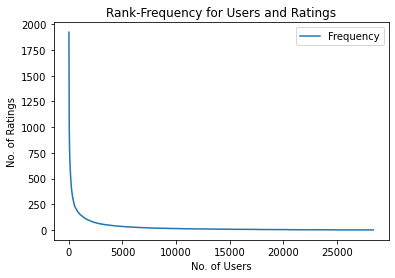

In [16]:
#### Number of user and number of ratings for each user
count1 = userDF2.groupBy(userDF.User).count()
count1 = count1 = count1.orderBy(count1["count"].desc())

pdf = count1.toPandas()

pdf = pdf.rename(columns = {"count": "Frequency"})
pdf.index.name = "No. of Users"
ax = pdf.plot(y = "Frequency", title = "Rank-Frequency for Users and Ratings")
ax.set(xlabel = "No. of Users", ylabel = "No. of Ratings")

# 2.1 c) Items, Ratings Rank Frequency Distribution

[Text(0, 0.5, 'No. of Ratings'), Text(0.5, 0, 'No. of Items')]

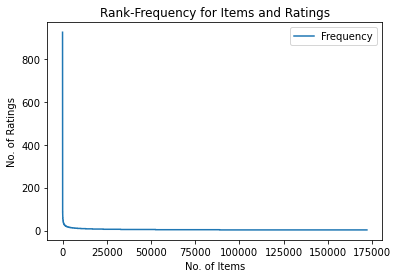

In [17]:
# number of Items and number of ratings of each item received
only_pap = userDF2.select("Paper_ID")
only_pap = only_pap.groupBy(only_pap.Paper_ID).count()
only_pap = only_pap.orderBy(only_pap["count"].desc())

pdf = only_pap.toPandas()

pdf = pdf.rename(columns = {"count": "Frequency"})
#pdf.index.name = "No. of Items"
ax = pdf.plot(y = "Frequency", title = "Rank-Frequency for Items and Ratings")
ax.set(xlabel = "No. of Items", ylabel = "No. of Ratings")

Yes, it does seems like power law and it has the long tail. (Items rank frequency has longer tail than users one.)

# Exercise 2.2 Ratings Matrix Preparation

In [18]:
# Using zipWithIndex() to give positive integers id to user_hash
# Creating Two RDDs 1: 
testrdd = userDF
id_papers = testrdd.rdd.zipWithIndex().map(lambda x: (x[1]+1, x[0][1]))
id_hash = testrdd.rdd.zipWithIndex().map(lambda x: (x[1]+1, x[0][0]))
id_hash.take(1)
id_papersDF = id_papers.toDF()
id_papersDF = id_papersDF.withColumn("id", id_papersDF._1).withColumn("papers", id_papersDF._2).drop("_1", "_2")
#testDF = testDF.select(testDF._1, sf.explode(testDF._2))
id_papersDF.show(2)

# Creating ID_UserHash DF so can mappen recommendations

id_hash = id_hash.toDF()
id_hash = id_hash.withColumn("id", id_hash._1).withColumn("user_hash", id_hash._2).drop("_1", "_2")
id_hash.show(2)

+---+--------------------+
| id|              papers|
+---+--------------------+
|  1|[1158654, 478707,...|
|  2|[3929762, 503574,...|
+---+--------------------+
only showing top 2 rows

+---+--------------------+
| id|           user_hash|
+---+--------------------+
|  1|f05bcffe7951de9e5...|
|  2|28d3f81251d94b097...|
+---+--------------------+
only showing top 2 rows



In [19]:
 
#userDF2 = userDF2.withColumn("Rating", lit(1))
#userDF2.show()
#userDF2.printSchema()

In [20]:
# Creating Set of papers.
# Using userDF2 because it already contains exploded papers column
sett = (userDF2.select("Paper_ID").distinct().collect())

In [21]:
mvv_array = [(row.Paper_ID) for row in sett]

#len(mvv_array)

paper_set = set(mvv_array)

#len(sett1)

In [22]:
# df_rated1 contains array of papers for each id along with ratings column.
df_rated1 = id_papersDF.withColumn("Ratings", lit(1))
df_rated1.show(2)

+---+--------------------+-------+
| id|              papers|Ratings|
+---+--------------------+-------+
|  1|[1158654, 478707,...|      1|
|  2|[3929762, 503574,...|      1|
+---+--------------------+-------+
only showing top 2 rows



In [23]:
# Converting spark DF to Pandas DF to process further by iterating rows.
df_pd = df_rated1.toPandas()

In [24]:
df_pd

,id,papers,Ratings
0,1,"[1158654, 478707, 12054725, 6670515, 781057, 1...",1
1,2,"[3929762, 503574, 5819422, 4238883, 5788061, 4...",1
2,3,"[2080631, 6343346, 5184704, 7756088, 2653863, ...",1
3,4,[278019],1
4,5,"[6610569, 6493797, 6609079, 7469737, 7469738, ...",1
...,...,...,...
28411,28412,"[7124210, 7691478, 5360268]",1
28412,28413,"[4061926, 4987472, 5142298, 7156686, 4651203, ...",1
28413,28414,"[5307378, 2659281, 7346434, 7179048, 408112, 5...",1
28414,28415,"[1392620, 1392141, 1208448, 1306455, 553429, 2...",1


In [25]:
# Creating Empty Pandas DataFrame
df_copy = pd.DataFrame([], columns = ["id", "paper_Set"])
df_copy

,id,paper_Set


In [26]:
# Iterating over row and selecting random sample from not rated paper for each user
start = time.time()
import random
for index, row in df_pd.iterrows():
    #print(row["id"], len(row["paper_Set"]))
    rated = set(row["papers"])
    not_rated = paper_set - rated
    selected = random.sample(not_rated, len(rated))
    idd = row["id"]
    count = len(selected)
    new_row = {"id" : idd, "paper_Set": selected}
    df_copy = df_copy.append(new_row, ignore_index=True)
end = time.time()
print(end - start)
#, "paper_count": len(selected)

480.4392669200897


In [27]:
# Back to spark DF.
df_rat0 = sqlC.createDataFrame(df_copy)

In [28]:
df_rat0.show(2)

+---+--------------------+
| id|           paper_Set|
+---+--------------------+
|  1|[8464677, 9778345...|
|  2|[5840780, 3503101...|
+---+--------------------+
only showing top 2 rows



In [29]:
# Exploding paper_Set so we get 1 paper per row.
df_rat0 = df_rat0.select(df_rat0.id, sf.explode(df_rat0.paper_Set))
# Adding 0 Rating for every user.
df_rat0 = df_rat0.withColumn("Paper_id", df_rat0["col"]).withColumn("Rating", lit(0))

In [30]:
df_rat0 = df_rat0.drop("col")
df_rat0.count()

828481

In [31]:
#Exploding df_rated1 DF. df_rat1 contains exploded papers column
df_rat1 = df_rated1.select(df_rated1.id, sf.explode(df_rated1.papers), df_rated1.Ratings)
df_rat1 = df_rat1.withColumn("paper", df_rat1["col"])
df_rat1 = df_rat1.drop("col").select(df_rat1.id, df_rat1.paper, df_rat1.Ratings)
df_rat1.show(2)

+---+-------+-------+
| id|  paper|Ratings|
+---+-------+-------+
|  1|1158654|      1|
|  1| 478707|      1|
+---+-------+-------+
only showing top 2 rows



In [32]:
# mixed DF contains both rated and unrated items for each user. 
# Number of rated items is equal to number of unrated items for every user.

mixed = df_rat0.union(df_rat1)
mixed = mixed.withColumn("paper_id", col("Paper_id").cast(IntegerType())).withColumn("rating", col("Rating").cast(IntegerType()))
#alles.count()
#mixed.printSchema()
mixed = mixed.orderBy(mixed.id)
mixed.show(2)

+---+--------+------+
| id|paper_id|rating|
+---+--------+------+
|  1| 8464677|     0|
|  1| 9778345|     0|
+---+--------+------+
only showing top 2 rows



# Exercise 2.3 ALS Algorithm

In [33]:
from pyspark.ml.recommendation import ALS


#Splitting Dataset into training(0.7) and testing(0.3)
(training, test) = mixed.randomSplit([0.7, 0.3])

# Building the recommendation model using ALS on the training data
als = ALS(maxIter=10, regParam=0.1, userCol="id", itemCol="paper_id", ratingCol="rating",\
          coldStartStrategy="drop")
model = als.fit(training)

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)

In [34]:
recs = userRecs

recs.show(1, False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |recommendations                                                                                                                                                                                                            |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|148|[[2391598, 0.9396941], [409021, 0.9240873], [276674, 0.91328865], [5836064, 0.9112915], [181433, 0.9106967], [8251943, 0.9057868], [4134071, 0.9054943], [550553, 0.90317327], [2639510, 0.9009899], [4149348, 0.89890575]]|
+---+-------------------------------------------------------------------------------------------

In [35]:
# Joining id_recommendations table with id_hash table to get hash_recommendations.
hash_rec = id_hash.join(recs, "id").select("user_hash", "recommendations")


In [36]:
hash_rec.show(2)

+--------------------+--------------------+
|           user_hash|     recommendations|
+--------------------+--------------------+
|38fe6373389d12b5b...|[[4085212, 0.8478...|
|ed571b13a83199c9c...|[[1108380, 0.9594...|
+--------------------+--------------------+
only showing top 2 rows



In [37]:
# Cleaning Recommendations as user_hash, paper_id and prediction for each user with it's 10 recommendations.
# For that registering Temporary Table.
hash_rec.registerTempTable("Paper_Rec")
clean = sqlC.sql("Select user_hash, recommendations1.paper_id as paper_id,recommendations1.rating as prediction FROM\
        Paper_Rec Lateral VIEW explode(recommendations) exploded_table as recommendations1 ")

In [38]:
clean.show()

+--------------------+--------+----------+
|           user_hash|paper_id|prediction|
+--------------------+--------+----------+
|38fe6373389d12b5b...| 4085212|0.84789664|
|38fe6373389d12b5b...| 8879965| 0.8412125|
|38fe6373389d12b5b...|12827448| 0.8337314|
|38fe6373389d12b5b...|12818217| 0.8333125|
|38fe6373389d12b5b...|12818248| 0.8322606|
|38fe6373389d12b5b...|  694910| 0.8304798|
|38fe6373389d12b5b...|13048613| 0.8244438|
|38fe6373389d12b5b...|12818244|0.82308084|
|38fe6373389d12b5b...| 7405186|0.82155067|
|38fe6373389d12b5b...|  771830| 0.8208304|
|ed571b13a83199c9c...| 1108380|  0.959422|
|ed571b13a83199c9c...| 6419204| 0.9123838|
|ed571b13a83199c9c...| 1539525| 0.9053011|
|ed571b13a83199c9c...|  150388|0.90338224|
|ed571b13a83199c9c...| 4665784|  0.900236|
|ed571b13a83199c9c...|  967051| 0.8974236|
|ed571b13a83199c9c...|  635281| 0.8949845|
|ed571b13a83199c9c...| 9362483|0.89184487|
|ed571b13a83199c9c...| 3733066| 0.8902151|
|ed571b13a83199c9c...|  844476|0.88813305|
+----------

# Exercise 2.4 Evaluate ALS model

In [39]:
# Evaluate the model by computing the RMSE on the test data
from pyspark.ml.evaluation import  RegressionEvaluator

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
# First Try reg = 0.1, iter 5: 0.48
# Second Try reg = 0.1, iter 10: 0.384
# Third Try reg = 0.1, iter 10: 0.360

Root-mean-square error = 0.3853716749541774


# Exercise 2.5 Tuning HyperParameters Cross Validator

In [40]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Creating paramGrid and adding parameters
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10,15,25])\
    .addGrid(als.regParam, [0.1]) \
    .addGrid(als.maxIter, [20]) \
    .build()

#Creating Evaluator
evaluator = RegressionEvaluator(labelCol="rating",
                                predictionCol="prediction",
                                metricName="rmse")

# Create CrossValidator and to perform cross validation using als
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator= evaluator,
                          numFolds=3)

# Fitting model using Cross Validation
cvModel = crossval.fit(training)

# Generate Predictions and use rmse to evaluate
prediction = cvModel.transform(test)
rmse = evaluator.evaluate(prediction)


# TRY 1: maxIter = 10
# Root Mean Squared Error (RMSE) on test data = 0.360828, Rank = 25

# TRY 2: maxIter = 15
# Root Mean Squared Error (RMSE) on test data = 0.353864 Rank = 25

# TRY 3: maxIter = 20
# Root Mean Squared Error (RMSE) on test data = 0.0.349647 Rank = 25

# Observation 
# By increasing the number of maxIter the rmse has decreased.
# Lower the rmse the better results/recommendations we will get.
# In general, lowest value of rmse is considered to be the best case for predictions.


In [41]:
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(cvModel.bestModel.rank)


Root Mean Squared Error (RMSE) on test data = 0.351073
25
